# Building up the forward model.
JAX does not allow updating arrays in-place. So I'll write a function that computes a single visibility, and vectorize from there with vmap or something.

I'll start with a straightfoward python implementation and use it for tests.

In [1]:
import numpy as np

In [23]:
import matplotlib.pyplot as plt

In [15]:
def test_compute_v(image: np.array, u: float, v: float):
    l, m = np.indices(image.shape)
    return np.sum(image * np.exp(-2 * np.pi * 1j * (u * l + v * m)))

Now test on things I know.

In [17]:
test_compute_v(np.zeros(shape=(5, 5)), 1., 1.)

0j

In [24]:
test_compute_v(np.ones(shape=(5, 5)), 1.3, 1.3)

(0.47213595499959715-1.4530850560107433j)

In [22]:
test_compute_v(np.ones(shape=(5, 5)), 0., 0.)

(25+0j)

In [45]:
u = np.arange(1 / 5 * 10, step=1 /5)
v = np.arange(1 / 5 * 10, step=1 /5)

In [46]:
im = np.ones(shape=(5,5))

In [47]:
im_ft = np.zeros(shape=(u.shape[0], v.shape[0]), dtype=np.complex)

In [48]:
im_ft.shape

(10, 10)

In [49]:
for i in range(len(u)):
    for j in range(len(v)):
        im_ft[i, j] = test_compute_v(im, u[i], v[j])

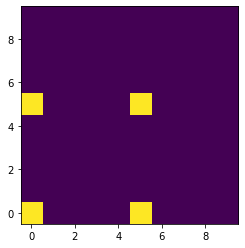

In [50]:
plt.imshow(np.abs(im_ft), origin='lower')

In [42]:
fft_im = np.fft.fft2(im)
freq_row = np.fft.fftfreq(im.shape[0],d=2)
freq_col = np.fft.fftfreq(im.shape[1],d=2)

In [77]:
fft_im

array([[25.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [43]:
freq_row

array([ 0. ,  0.1,  0.2, -0.2, -0.1])

In [51]:
freq_col

array([ 0. ,  0.1,  0.2, -0.2, -0.1])

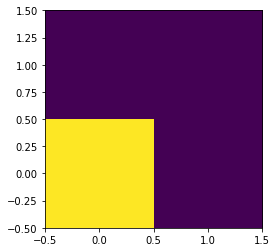

In [52]:
plt.imshow(np.abs(fft_im[0:2, 0:2]), origin='lower')

So at least for FFT with a constant function...My DFT function looks sane. I'll park that for now. Next I'll grab some images and double check those.

# Now, JAXify

In [53]:
import jax.numpy as jnp

In [61]:
from jax import jit

In [68]:
import jax

In [67]:
def compute_v(image: jnp.array, lm: jnp.array, u: float, v: float):
    l, m = lm
    return jnp.sum(image * jnp.exp(-2 * np.pi * 1j * (u * l + v * m)))

lm = jnp.indices(im.shape)
lm = jax.device_put(lm)

In [81]:
im_d = jax.device_put(im)

I went back and modify `compute_v` to take the lm matrix and put the lm matrix on the device first

In [65]:
# without lm on the device
%timeit compute_v(im, 0, 0)

2.06 ms ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
# with lm on the device
%timeit compute_v(im, lm, 0, 0)

719 µs ± 41.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [72]:
fast_compute_v = jit(compute_v)

Putting lm on the device actually didn't make that much of a difference for the jit'd function.

In [76]:
fast_compute_v(im, lm, 0, 0)

DeviceArray(25.+0.j, dtype=complex64)

In [79]:
fast_compute_v(im, lm, 0.2, 0.2)

DeviceArray(-1.4305115e-06+8.940697e-07j, dtype=complex64)

In [82]:
%timeit fast_compute_v(im_d, lm, 0, 0)

373 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


How long does this take with numpy?

In [83]:
%timeit test_compute_v(im, 0., 0.)

22.3 µs ± 710 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now let's vmap this